In [7]:
import numpy as np
import pandas as pd
import rpy2.robjects.packages as rpackages
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
%matplotlib notebook
import matplotlib.pyplot as plt

In [8]:
import sys
import os
sys.path.append(os.path.abspath('C:/Users/william.bouchut/Documents/Work/LabTools'))

from plotting.stats_plots import get_bias, get_loa

In [9]:
import rpy2
print(rpy2.__version__)

3.5.10


In [10]:
PATH_RESULTS = r"C:\Users\william.bouchut\Documents\Work\Neo_Kopfball\result_analysis\Table_result_reliability_Jun_12_2023_(17h_01m).xlsx"

In [11]:
# import R's utility package
utils = rpackages.importr('utils')
# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001B97A884480> [RTYPES.NILSXP]

In [ ]:
# NEED TO INSTALL MANUALLY VIA R-STUDIO WHEN NO ADMIN PERMISSION...
# R package names
packnames = [('irr'), ('blandr'), ('colorspace'), ('htmltools'), ('pandoc')]

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    print(names_to_install)
    utils.install_packages(StrVector(names_to_install))

R[write to console]: Warning in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  :
R[write to console]: 
 
R[write to console]:  'lib = "C:/Program Files/R/R-4.2.2/library" ist nicht schreibbar

R[read into console]: 'utf-8' codec can't decode byte 0xf6 in position 14: invalid start byte
R[write to console]: Error in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  : 
  kann keine Pakete installieren



['irr', 'blandr', 'colorspace', 'htmltools', 'pandoc']


RRuntimeError: Error in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  : 
  kann keine Pakete installieren


In [12]:
irr = importr('irr')
blandr  = importr('blandr')

In [13]:
def bland_altman_plot_from_r_output(var1: pd.DataFrame, var2: pd.DataFrame, **kwargs):
    comparison = pd.concat([var1, var2], axis=1)
    with localconverter(ro.default_converter + pandas2ri.converter):
        data = ro.conversion.py2rpy(comparison)
    ba_res = blandr.blandr_statistics(data[0], data[1])
    ba_res_dict = dict(zip(ba_res.names, map(list,list(ba_res))))
    
    
    
    icc = irr.icc(data, model = "twoway", type="agreement")
    icc_dict = dict(zip(icc.names, map(list,list(icc))))
    
    icc_val_string = f'{icc_dict["value"][0]:.2f}'
    icc_lbound_string = f'{icc_dict["lbound"][0]:.2f}'
    icc_ubound_string = f'{icc_dict["ubound"][0]:.2f}'
    
    icc_string = f'\n(ICC: {icc_val_string} [{icc_lbound_string}...{icc_ubound_string}])'
    
    
    
    figsize = kwargs.get('figsize', (8, 6))
    title = kwargs.get('title', "Bland-Altman Plot")
    x_label = kwargs.get('x_label', f'Means')
    y_label = kwargs.get('y_label', f'Differences')
    ylim = kwargs.get('ylim', None)
    
    
        
    ax = kwargs.get('axis')
    fig = kwargs.get('fig')
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(ba_res_dict["means"], ba_res_dict["differences"], 10, color='k')
    ax.axhline(0, color='k')


    ax.axhline(ba_res_dict["bias"], color='k', linestyle='--')
    ax.axhline(ba_res_dict["biasUpperCI"], color='k', linestyle=':')
    ax.axhline(ba_res_dict["biasLowerCI"], color='k', linestyle=':')

    init_x_lim = ax.get_xlim()
    a = 0.1
    col = 'k'
    ax.fill_between(init_x_lim, ba_res_dict["biasUpperCI"], ba_res_dict["biasLowerCI"], color=col, alpha=a)

    ax.axhline(ba_res_dict["lowerLOA"], color='k', linestyle='--')
    ax.axhline(ba_res_dict["lowerLOA_upperCI"], color='k', linestyle=':')
    ax.axhline(ba_res_dict["lowerLOA_lowerCI"], color='k', linestyle=':')
    ax.fill_between(init_x_lim, ba_res_dict["lowerLOA_upperCI"], ba_res_dict["lowerLOA_lowerCI"], color=col, alpha=a)

    ax.axhline(ba_res_dict["upperLOA"], color='k', linestyle='--')
    ax.axhline(ba_res_dict["upperLOA_upperCI"], color='k', linestyle=':')
    ax.axhline(ba_res_dict["upperLOA_lowerCI"], color='k', linestyle=':')
    ax.fill_between(init_x_lim, ba_res_dict["upperLOA_upperCI"], ba_res_dict["upperLOA_lowerCI"], color=col, alpha=a)

    ax.set_xlim(init_x_lim)
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.set_title(title + icc_string)
    return ax

In [19]:
def reliability_plots_neo(sheet, outcome_name):
    df = pd.read_excel(PATH_RESULTS, index_col=0, sheet_name=sheet)
    ses1 = df[f'session1_{outcome_name}']
    ses2 = df[f'session2_{outcome_name}']
    ses3 = df[f'session3_{outcome_name}']
    plt.close()
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 4), sharey=True)  # (18, 5) without %matplotlib notebook

    ax1 = bland_altman_plot_from_r_output(ses1, ses2, axis=ax1, title="S1 - S2")
    ax2 = bland_altman_plot_from_r_output(ses1, ses3, axis=ax2, title="S1 - S3", y_label="")
    ax3 = bland_altman_plot_from_r_output(ses2, ses3, axis=ax3, title="S2 - S3", y_label="")
    fig.suptitle(f'Bland-Altman Plots - {outcome_name} ({sheet})')
    fig.tight_layout()
    plt.savefig(f'../../result_analysis/plots/png/{outcome_name}_{sheet}.png')
    plt.savefig(f'../../result_analysis/plots/svg/{outcome_name}_{sheet}.svg')

In [16]:
#Latency of the First Saccade

In [17]:
sheet_names = ['biflicker'] #, 'vertical_biflicker', 'antibiflicker', 'vertical_antibiflicker']

<IPython.core.display.Javascript object>


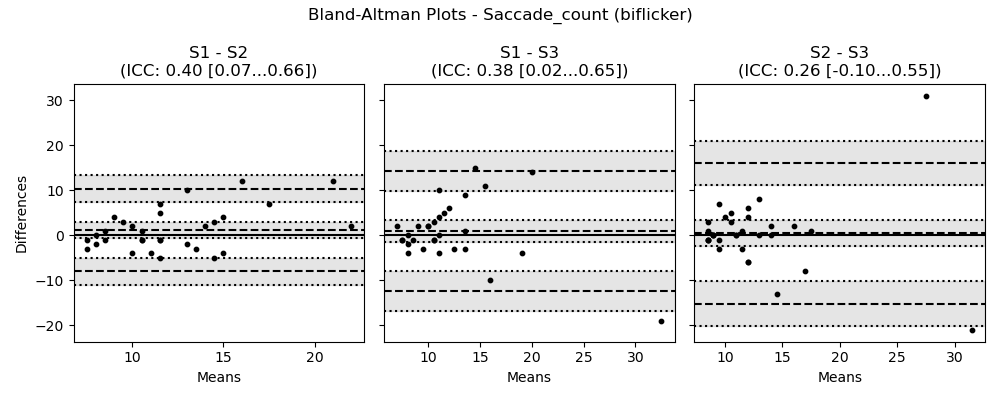

In [21]:
for sheet in sheet_names:
#     reliability_plots_neo(sheet, "Latency_of_the_first_saccade_ms")
#     reliability_plots_neo(sheet, "Directional_error")
#     reliability_plots_neo(sheet, "Peak_velocity_of_the_first_saccade")
#    reliability_plots_neo(sheet, "Gain_of_the_first_saccade")
     reliability_plots_neo(sheet, "Saccade_count")
    